In [ ]:
!pip install torch torchvision matplotlib pillow

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
from PIL import Image
import os


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download CIFAR-10 dataset automatically
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Use a small subset for faster training
dataset = Subset(dataset, range(500))

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 49.9MB/s]


In [ ]:
def train_and_evaluate(model, model_name, num_epochs=5, lr=0.001):
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import time

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_acc_list, val_acc_list = [], []
    train_loss_list, val_loss_list = [], []

    start_time = time.time()

    for epoch in range(num_epochs):
        # Training
        model.train()
        correct, total, running_loss = 0, 0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)

            # ✅ Fix for GoogLeNet / Inception outputs
            if hasattr(outputs, "logits"):
                outputs_main = outputs.logits
            elif isinstance(outputs, tuple):
                outputs_main = outputs[0]
            else:
                outputs_main = outputs

            # If aux_logits exist, you can optionally include them
            aux_loss = 0
            if hasattr(outputs, "aux_logits") and outputs.aux_logits is not None:
                aux_loss += 0.3 * criterion(outputs.aux_logits[0], labels)
                aux_loss += 0.3 * criterion(outputs.aux_logits[1], labels)

            main_loss = criterion(outputs_main, labels)
            loss = main_loss + aux_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs_main, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        train_loss = running_loss / len(train_loader)
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)

        # Validation
        model.eval()
        correct, total, val_running_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                if hasattr(outputs, "logits"):
                    outputs_main = outputs.logits
                elif isinstance(outputs, tuple):
                    outputs_main = outputs[0]
                else:
                    outputs_main = outputs

                val_loss = criterion(outputs_main, labels)
                val_running_loss += val_loss.item()

                _, predicted = torch.max(outputs_main, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        val_loss = val_running_loss / len(val_loader)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        print(f"{model_name} Epoch {epoch+1}/{num_epochs} - "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    total_time = time.time() - start_time
    print(f"\n🔹 Total training time for {model_name}: {total_time:.2f} sec")

    return model, train_acc_list, val_acc_list, train_loss_list, val_loss_list, total_time


In [ ]:
import torch.nn as nn
import torchvision.models as models
from torchvision.models import VGG16_Weights, ResNet18_Weights, GoogLeNet_Weights

def get_model(name):
    if name == "vgg":
        model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        model.classifier[6] = nn.Linear(4096, 10)  # CIFAR-10 has 10 classes

    elif name == "resnet":
        model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, 10)

    elif name == "googlenet":
        model = models.googlenet(weights=GoogLeNet_Weights.IMAGENET1K_V1, aux_logits=True)
        model.fc = nn.Linear(model.fc.in_features, 10)
        # Update auxiliary heads to match CIFAR-10
        model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, 10)
        model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, 10)

    else:
        raise ValueError("Unknown model name. Choose from: vgg, resnet, googlenet")

    return model


In [ ]:
results = {}
trained_models = {}

for model_name in ["vgg", "resnet", "googlenet"]:
    model = get_model(model_name)
    trained_model, train_acc, val_acc, train_loss, val_loss, total_time = train_and_evaluate(
        model, model_name.upper(), num_epochs=5
    )

    results[model_name] = {
        "train_acc": train_acc,
        "val_acc": val_acc,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "training_time": total_time
    }

    trained_models[model_name] = trained_model

VGG Epoch 1/5 - Train Acc: 11.25%, Val Acc: 9.00%, Train Loss: 3.3379, Val Loss: 3.7257
VGG Epoch 2/5 - Train Acc: 9.75%, Val Acc: 12.00%, Train Loss: 2.6699, Val Loss: 2.3295
VGG Epoch 3/5 - Train Acc: 11.25%, Val Acc: 9.00%, Train Loss: 2.3111, Val Loss: 2.3341
VGG Epoch 4/5 - Train Acc: 14.50%, Val Acc: 7.00%, Train Loss: 2.2898, Val Loss: 2.3261
VGG Epoch 5/5 - Train Acc: 11.25%, Val Acc: 9.00%, Train Loss: 2.3055, Val Loss: 2.3021

🔹 Total training time for VGG: 34.13 sec
RESNET Epoch 1/5 - Train Acc: 38.50%, Val Acc: 23.00%, Train Loss: 1.6527, Val Loss: 6.5388
RESNET Epoch 2/5 - Train Acc: 80.00%, Val Acc: 32.00%, Train Loss: 0.6163, Val Loss: 6.5876
RESNET Epoch 3/5 - Train Acc: 90.25%, Val Acc: 43.00%, Train Loss: 0.3282, Val Loss: 2.4869
RESNET Epoch 4/5 - Train Acc: 94.25%, Val Acc: 45.00%, Train Loss: 0.2046, Val Loss: 2.3108
RESNET Epoch 5/5 - Train Acc: 96.25%, Val Acc: 44.00%, Train Loss: 0.1090, Val Loss: 2.2209

🔹 Total training time for RESNET: 10.04 sec
GOOGLENET Epo

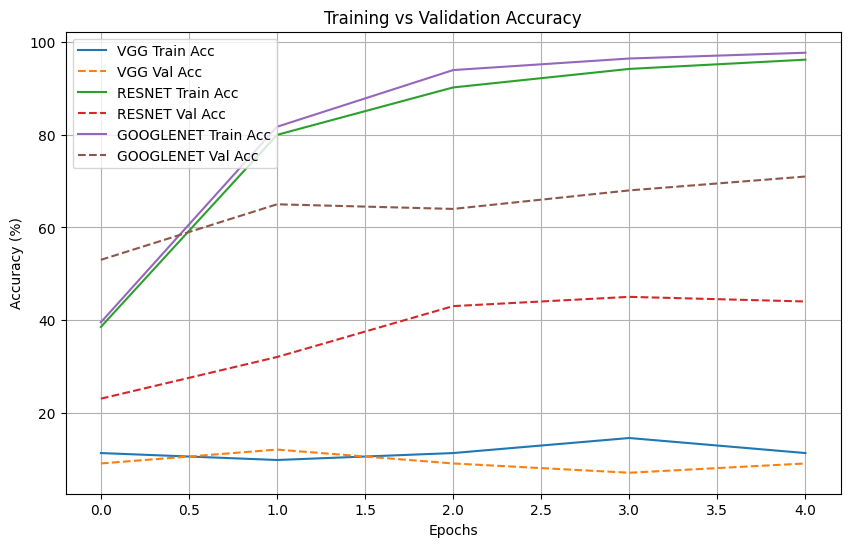

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for model_name in results.keys():
    plt.plot(results[model_name]["train_acc"], label=f"{model_name.upper()} Train Acc")
    plt.plot(results[model_name]["val_acc"], linestyle='--', label=f"{model_name.upper()} Val Acc")

plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

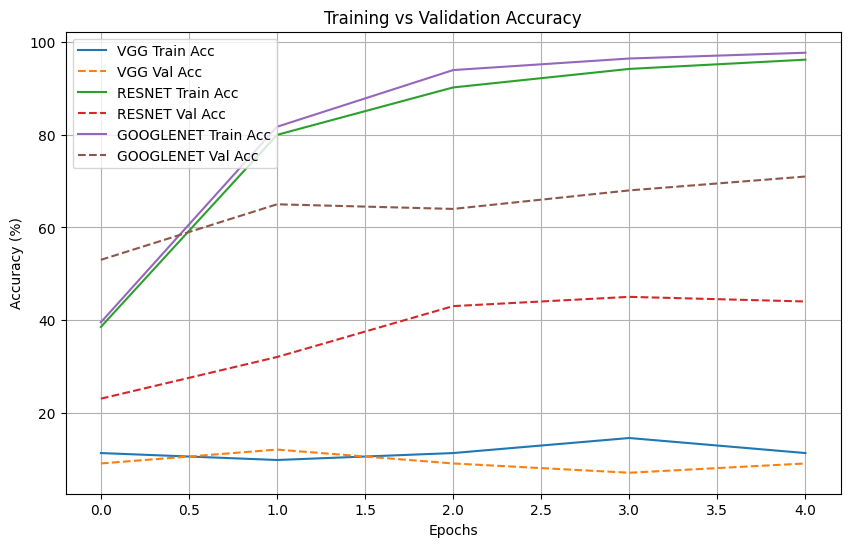

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for model_name in results.keys():
    plt.plot(results[model_name]["train_acc"], label=f"{model_name.upper()} Train Acc")
    plt.plot(results[model_name]["val_acc"], linestyle='--', label=f"{model_name.upper()} Val Acc")

plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()


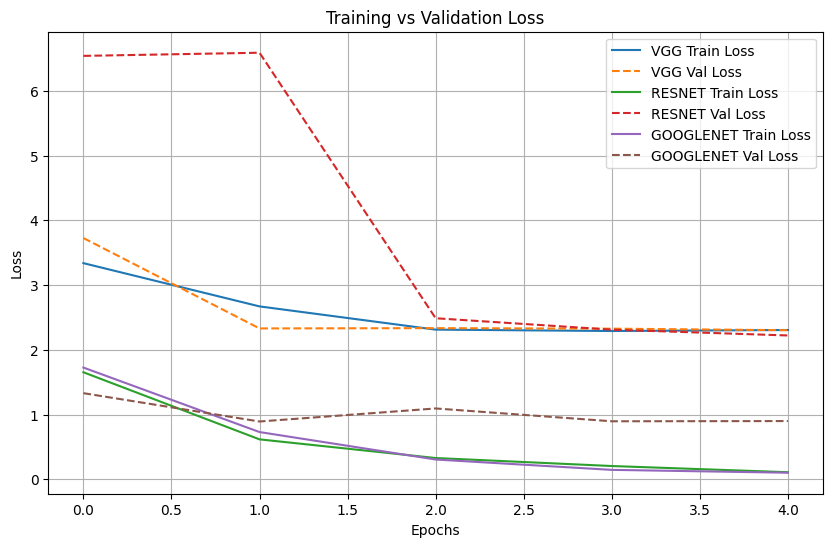

In [ ]:
plt.figure(figsize=(10,6))
for model_name in results.keys():
    plt.plot(results[model_name]["train_loss"], label=f"{model_name.upper()} Train Loss")
    plt.plot(results[model_name]["val_loss"], linestyle='--', label=f"{model_name.upper()} Val Loss")

plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()